In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy import stats
from mlxtend.plotting import scatterplotmatrix

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import streamlit as st

In [11]:
st.set_page_config(layout="wide")
st.write(""" # Automatisering av låneprosessen""")

In [12]:
raw_data = pd.read_csv('imputed_new.csv', sep=',', index_col=False) # Naming the preprocessed train data "raw_data"
test_data = pd.read_csv('imputed_test_new.csv', sep=',', index_col=False) # Naming the preprocessed test data "test_data"

In [13]:
st.sidebar.header("Inndata verdier")

DeltaGenerator(_root_container=1, _provided_cursor=None, _parent=DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None), _block_type=None, _form_data=None)

In [14]:
print(raw_data.isnull().sum()) # Checking how many NaN there are
raw_data.head()

Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Gender_Male          0
Married_Yes          0
Self_Employed_Yes    0
Loan_Status_Y        0
dtype: int64


,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Married_Yes,Self_Employed_Yes,Loan_Status_Y
0,0.0,0.0,5849.0,0.0,128.0,360.0,1.0,2.0,1.0,0.0,0.0,1.0
1,1.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,3000.0,0.0,66.0,360.0,1.0,2.0,1.0,1.0,1.0,1.0
3,0.0,1.0,2583.0,2358.0,120.0,360.0,1.0,2.0,1.0,1.0,0.0,1.0
4,0.0,0.0,6000.0,0.0,141.0,360.0,1.0,2.0,1.0,0.0,0.0,1.0


In [15]:
def brukerverdier():
    Gender_Male = st.sidebar.selectbox("Gender", ["Male", "Female"])
    Married_Yes = st.sidebar.selectbox("Married?", ["Yes", "No"])
    Dependents = st.sidebar.slider("Dependents",0,10)
    Education = st.sidebar.selectbox("Education", ["Graduate", "Not Graduate"])
    Self_Employed_Yes = st.sidebar.selectbox("Self Employed", ["Yes", "No"])
    ApplicantIncome = st.sidebar.slider("ApplicantIncome",float(raw_data.ApplicantIncome.min()),float(raw_data.ApplicantIncome.max()),float(raw_data.ApplicantIncome.mean()))
    CoapplicantIncome = st.sidebar.slider("CoapplicantIncome",float(raw_data.CoapplicantIncome.min()),float(raw_data.CoapplicantIncome.max()),float(raw_data.CoapplicantIncome.mean()))
    LoanAmount = st.sidebar.slider("Loan_Amount",float(raw_data.LoanAmount.min()),float(raw_data.LoanAmount.max()),float(raw_data.LoanAmount.mean()))
    Loan_Amount_Term = st.sidebar.slider("Loan_Amount_Term",float(raw_data.Loan_Amount_Term.min()),float(raw_data.Loan_Amount_Term.max()),float(raw_data.Loan_Amount_Term.mean()))
    Credit_History = st.sidebar.slider("Credit_History",0,1)
    Property_Area = st.sidebar.selectbox("Property area?", ["Urban","Semiurban","Rural"])
    
    data = {
            "Dependents": Dependents,
            "Gender" : Gender_Male,
            "Married":Married_Yes,
            "Education": Education,
            "Self_Employed" : Self_Employed_Yes,
            "ApplicantIncome": ApplicantIncome,
            "CoapplicantIncome" : CoapplicantIncome,
            "Loan_Amount": LoanAmount,
            "Loan_Amount_Term": Loan_Amount_Term,
            "Credit_History" : Credit_History,
            "Property_Area" : Property_Area
            }
    features = pd.DataFrame(data, index=[0])

    return features

In [16]:
pred_user = brukerverdier()
st.write("")
st.write("")
st.write("")
st.write("")
st.write("")
st.write("")
#st.dataframe(data=pred_user, width=1200, height=768)
#st.dataframe(pred_user)
st.write(""" ## Se om du fortsatt vil få lån dersom du endrer noen parametere""")
st.write(""" ### Dine nye parametere""")
st.table(pred_user)
#st.write(pred_user)

pred_user["Gender"].replace({"Male":1 , "Female":0 }, inplace = True)
pred_user["Married"].replace({"Yes":1 , "No": 0 }, inplace = True)
pred_user["Education"].replace({"Graduate":0 , "Not Graduate": 1 }, inplace = True)
pred_user["Self_Employed"].replace({"Yes": 1 , "No": 0}, inplace = True )
pred_user["Property_Area"].replace({"Rural":0 ,"Semiurban": 1 , "Urban":2 }, inplace = True )


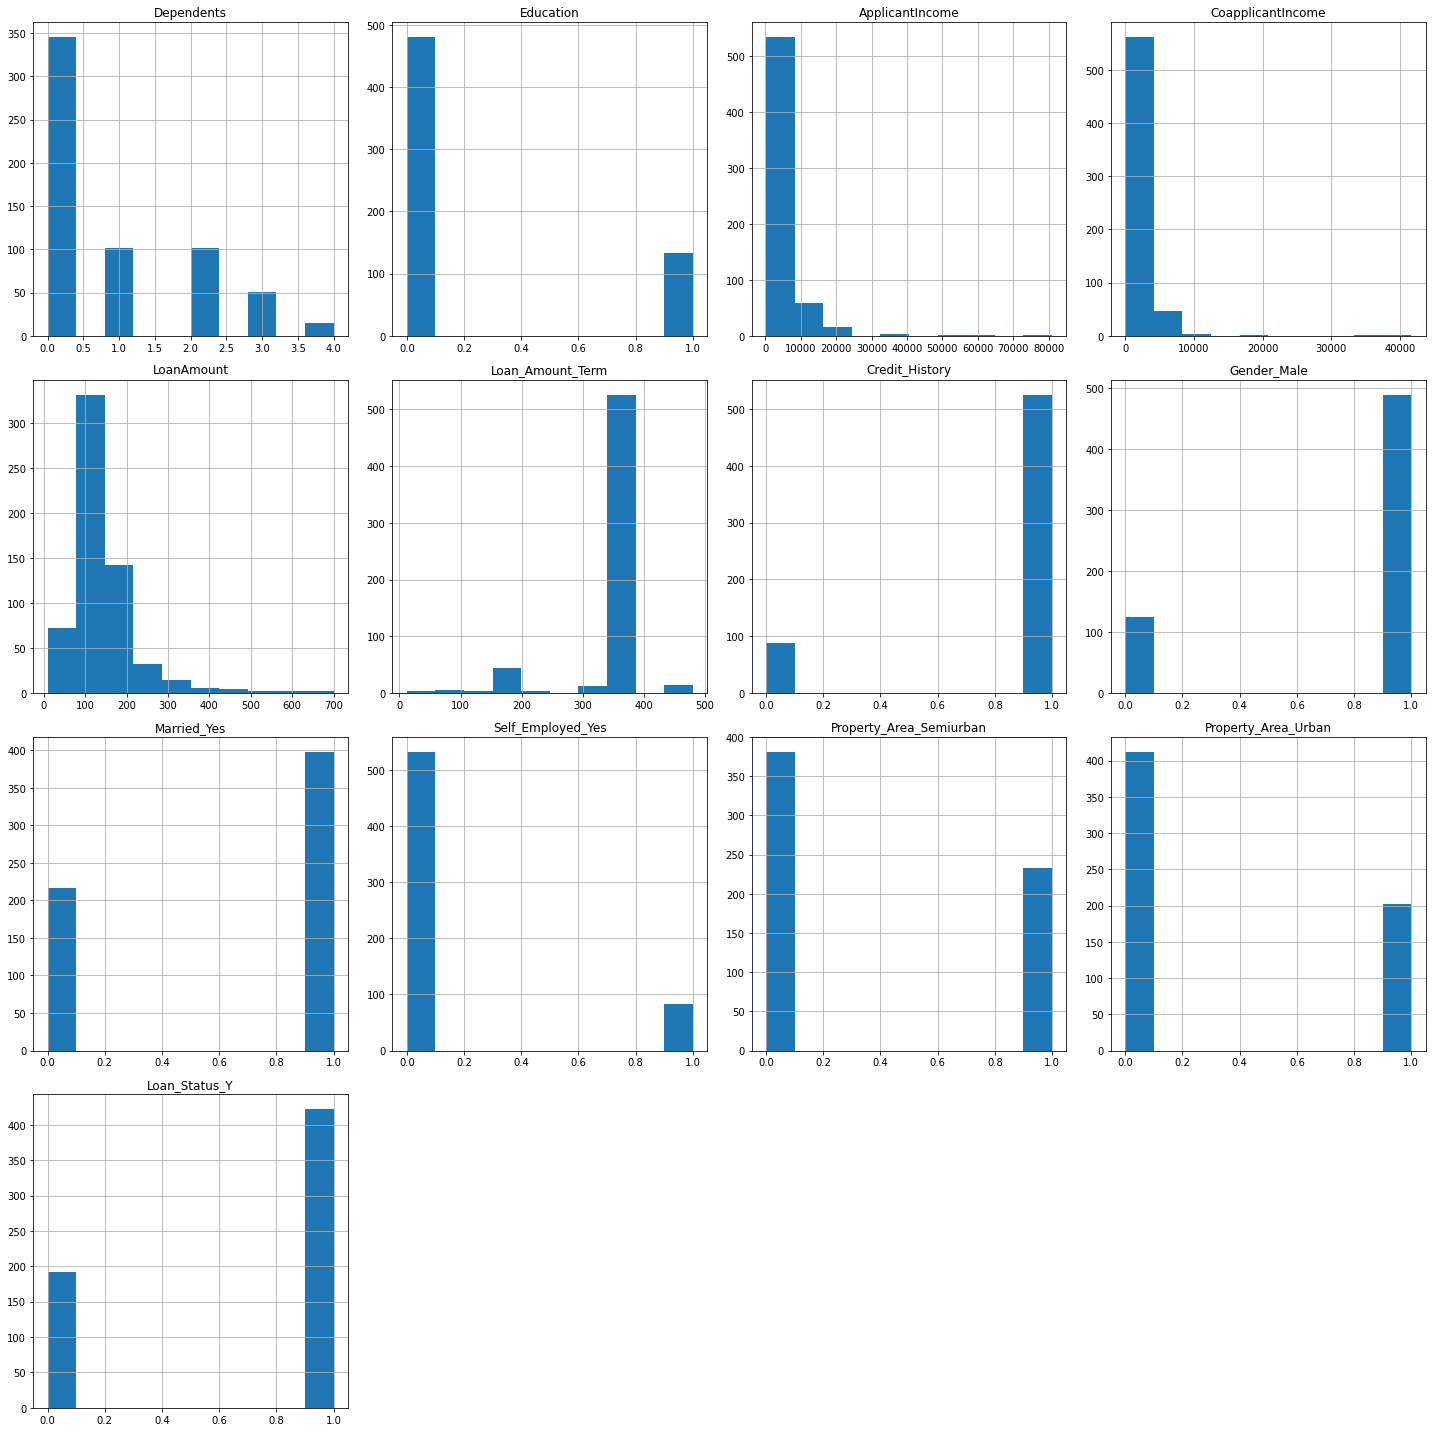

In [40]:
# Histograms below

raw_data.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

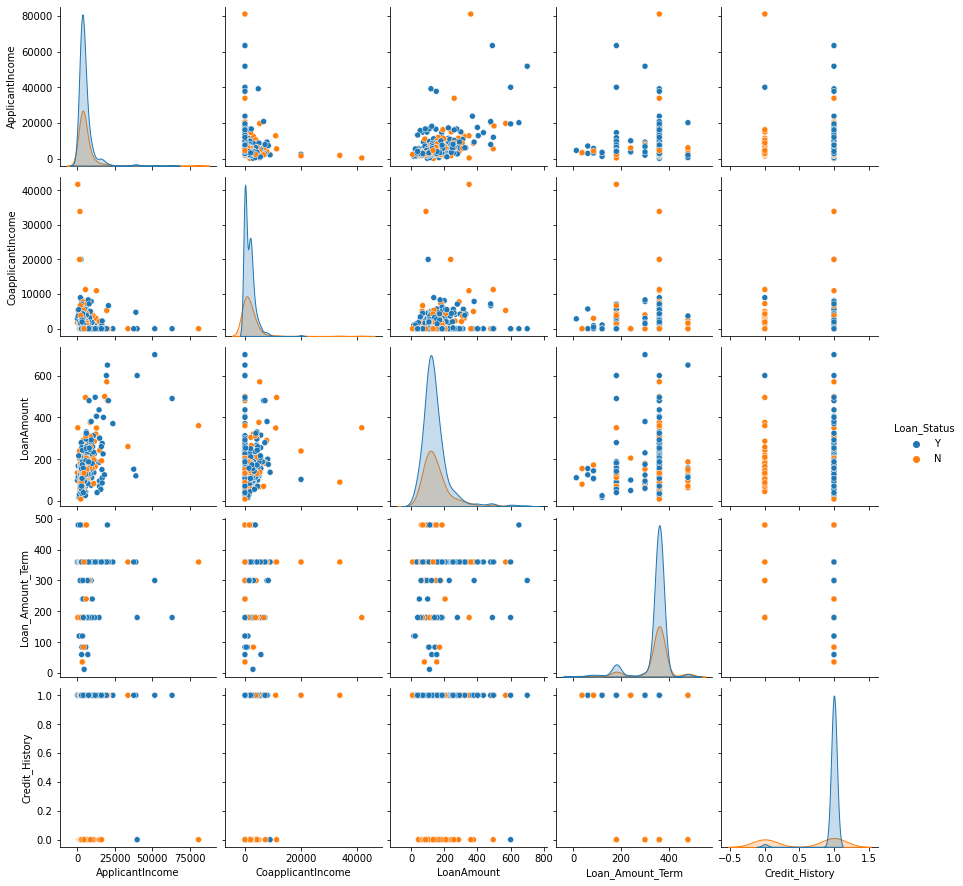

In [10]:
# Pairplots below

sns.pairplot(raw_data, hue='Loan_Status')

### Correlation Matrix

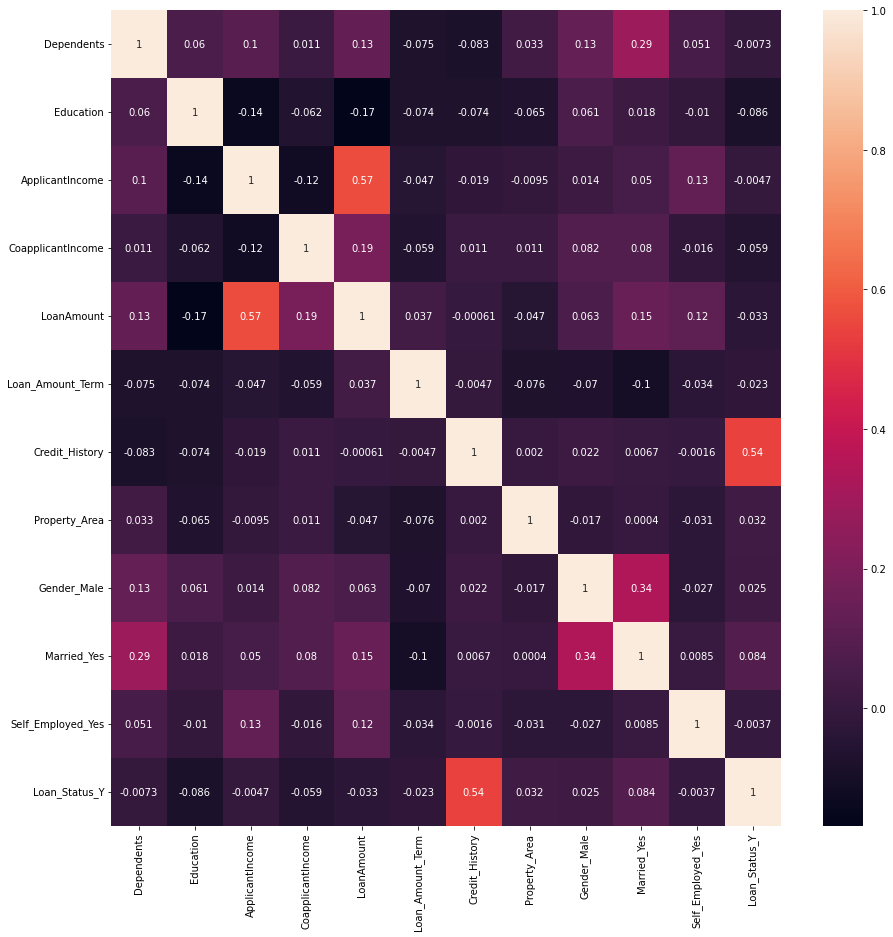

In [17]:
# Correlation matrix

plt.figure(figsize=(15, 15)) # Making it big for easier inspection
corr_matrix = raw_data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

We see that loan status positively correlates with both applicant income and credit history. Loan amount also correlates with both applicant income and credit history.
Something to note is that married males also positively correlate higher with loan status than unmarried males.
We have to look at that with skepticism since gender should not be something that makes it easier or harder to get a loan.

### Preprocessing

In [42]:
X = raw_data.drop(['Loan_Status_Y'], axis=1)
y = raw_data['Loan_Status_Y']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(429, 12) (185, 12) (429,) (185,)


### Gradient Boosting Classifier

In [44]:
gbc_pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier( learning_rate= 0.01,
                                                                        max_depth= 6, 
                                                                        max_features= 0.3,
                                                                        min_samples_leaf= 3,
                                                                        n_estimators= 500,
                                                                      random_state=21))

gbc_pipe.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features=0.3,
                                            min_samples_leaf=3,
                                            n_estimators=500,
                                            random_state=21))])

In [47]:
y_pred = gbc_pipe.predict(test_data)
pred_streamlit = gbc_pipe.predict(pred_user)

print('Gradient boosting regressor training data accuracy: {0:.2f}'.format(gbc_pipe.score(X_train, y_train)))

print('Gradient boosting regressor test data accuracy: {0:.2f}'.format(gbc_pipe.score(X_test, y_test)))

Gradient boosting regressor training data accuracy: 0.91
Gradient boosting regressor test data accuracy: 0.91


C:\Users\Arterx\Anaconda3\envs\dat200\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Gender
- Loan_Amount
- Married
- Self_Employed
Feature names seen at fit time, yet now missing:
- Gender_Male
- LoanAmount
- Married_Yes
- Self_Employed_Yes

  warnings.warn(message, FutureWarning)


In [48]:
if pred_streamlit == 0: 
    st.write("Basert på dette får du lån  ")
elif pred_streamlit> 0:
    st.write("Basert på dette får du ikke lån  ")